In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [20]:
df = pd.read_csv('policies.csv')
df.head()

,policy_id,customer_id,customer_age,customer_gender,marital_status,num_dependents,country,income_band,product_type,coverage_amount,...,critical_illness_rider,disability_rider,late_payment_count,customer_service_calls,beneficiary_updated,premium_change_pct,churned,churn_reason,snapshot_date,data_version
0,P000000,C000860,29,M,Married,0,US,Low,Universal,163000,...,False,False,0,1,True,-0.02,False,NaN,30/06/2024,v1.0
1,P000001,C001294,47,F,Married,1,DE,Ultra,Term,62000,...,False,False,0,1,False,-0.08,False,NaN,30/06/2024,v1.0
2,P000002,C001130,57,M,Single,0,DE,Mid,Universal,196000,...,False,False,1,0,False,0.14,False,NaN,30/06/2024,v1.0
3,P000003,C001095,29,F,Single,3,FR,Low,Universal,140000,...,False,False,2,1,False,0.01,False,NaN,30/06/2024,v1.0
4,P000004,C001638,47,F,Divorced,3,FR,NaN,Whole,333000,...,False,False,1,0,False,0.06,False,NaN,30/06/2024,v1.0


## Sanity Check of the data

In [19]:
print(f"Dataset shape: {df.shape}")

Dataset shape: (6000, 32)


In [21]:
df.dtypes

policy_id                  object
customer_id                object
customer_age                int64
customer_gender            object
marital_status             object
num_dependents              int64
country                    object
income_band                object
product_type               object
coverage_amount             int64
premium                   float64
payment_frequency          object
policy_start_date          object
policy_end_date            object
tenure_months               int64
renewal_count               int64
acquisition_channel        object
agent_id                   object
discount_applied             bool
discount_rate             float64
has_rider                    bool
num_riders                  int64
critical_illness_rider       bool
disability_rider             bool
late_payment_count          int64
customer_service_calls      int64
beneficiary_updated          bool
premium_change_pct        float64
churned                      bool
churn_reason  

the datatyoe of all the date fields is object and not datetime. it can be a problem.

In [8]:
df.isnull().sum()

policy_id                    0
customer_id                  0
customer_age                 0
customer_gender              0
marital_status               0
num_dependents               0
country                      0
income_band                553
product_type                 0
coverage_amount              0
premium                      0
payment_frequency            0
policy_start_date            0
policy_end_date           5208
tenure_months                0
renewal_count                0
acquisition_channel          0
agent_id                  3297
discount_applied             0
discount_rate             4504
has_rider                    0
num_riders                   0
critical_illness_rider       0
disability_rider             0
late_payment_count           0
customer_service_calls       0
beneficiary_updated          0
premium_change_pct           0
churned                      0
churn_reason              5208
snapshot_date                0
data_version                 0
dtype: i

In [13]:
df.describe()

,customer_age,num_dependents,coverage_amount,premium,tenure_months,renewal_count,discount_rate,num_riders,late_payment_count,customer_service_calls,premium_change_pct
count,6000.000000,6000.000000,6.000000e+03,6000.000000,6000.000000,6000.000000,1496.000000,6000.000000,6000.000000,6000.000000,6000.000000
mean,44.408833,1.178000,2.130965e+05,207.732770,83.795333,6.526833,0.148295,0.638333,0.594667,0.819833,0.031437
std,12.022705,1.073239,1.713029e+05,199.602361,49.101286,4.101636,0.058574,1.093189,0.767769,0.923137,0.079971
min,18.000000,0.000000,1.100000e+04,7.830000,1.000000,0.000000,0.050000,0.000000,0.000000,0.000000,-0.260000
25%,36.000000,0.000000,1.030000e+05,85.267500,42.000000,3.000000,0.100000,0.000000,0.000000,0.000000,-0.020000
50%,44.000000,1.000000,1.640000e+05,147.760000,82.000000,6.000000,0.150000,0.000000,0.000000,1.000000,0.030000
75%,53.000000,2.000000,2.670000e+05,256.035000,123.000000,10.000000,0.200000,1.000000,1.000000,1.000000,0.080000
max,85.000000,5.000000,1.893000e+06,2346.560000,176.000000,14.000000,0.250000,7.000000,5.000000,6.000000,0.360000


## Data Quality Issues Found

 Issue 1: Date columns stored as object (text) instead of datetime
 policy_start_date, policy_end_date, snapshot_date
Impact: Cannot perform date calculations or time-based filtering


In [24]:
df[['policy_start_date', 'policy_end_date', 'snapshot_date']].dtypes

policy_start_date    object
policy_end_date      object
snapshot_date        object
dtype: object

### Issue 2: Missing values in income_band (~9%)
- No clear pattern by country - distributed evenly across all countries
- Decision: Keep as missing, note limitation for income-based analysis

In [25]:
pd.crosstab(df['country'], df['income_band'].isnull(), normalize='index')



income_band,False,True
country,,
DE,0.917688,0.082312
ES,0.899061,0.100939
FR,0.893791,0.106209
IT,0.909639,0.090361
UK,0.909692,0.090308
US,0.909213,0.090787


### Issue 3: Unknown gender values (~4%)
- 255 records with customer_gender = "U"
- Decision: Keep as-is, not critical for current analysis

In [27]:
df['customer_gender'].value_counts()

customer_gender
F    2887
M    2858
U     255
Name: count, dtype: int64

### Decisions:

| Issue | Action |
|-------|--------|
| Date columns | Converted to datetime |
| income_band missing | Replaced with "Unknown" |
| Gender "U" | Left as-is - not critical for analysis |

### Decisions performance

In [33]:
## change date types from 'object' to 'datetime
df['policy_start_date'] = pd.to_datetime(df['policy_start_date'], dayfirst=True)
df['policy_end_date'] = pd.to_datetime(df['policy_end_date'], dayfirst=True)
df['snapshot_date'] = pd.to_datetime(df['snapshot_date'], dayfirst=True)


In [34]:
df['income_band'] = df['income_band'].fillna('Unknown')

In [35]:
df.head().T

,0,1,2,3,4
policy_id,P000000,P000001,P000002,P000003,P000004
customer_id,C000860,C001294,C001130,C001095,C001638
customer_age,29,47,57,29,47
customer_gender,M,F,M,F,F
marital_status,Married,Married,Single,Single,Divorced
num_dependents,0,1,0,3,3
country,US,DE,DE,FR,FR
income_band,Low,Ultra,Mid,Low,Unknown
product_type,Universal,Term,Universal,Universal,Whole
coverage_amount,163000,62000,196000,140000,333000


In [36]:
df.dtypes

policy_id                         object
customer_id                       object
customer_age                       int64
customer_gender                   object
marital_status                    object
num_dependents                     int64
country                           object
income_band                       object
product_type                      object
coverage_amount                    int64
premium                          float64
payment_frequency                 object
policy_start_date         datetime64[ns]
policy_end_date           datetime64[ns]
tenure_months                      int64
renewal_count                      int64
acquisition_channel               object
agent_id                          object
discount_applied                    bool
discount_rate                    float64
has_rider                           bool
num_riders                         int64
critical_illness_rider              bool
disability_rider                    bool
late_payment_cou

### Exploratory Analysis

In [37]:
# === Question 1: Characteristics associated with churn ===

# Churn rate by categorical variables
def churn_by_category(df, column):
    return df.groupby(column)['churned'].agg(['mean', 'count']).sort_values('mean', ascending=False)

print("=== Churn Rate by Customer & Policy Characteristics ===\n")

for col in ['product_type', 'acquisition_channel', 'payment_frequency', 
            'marital_status', 'income_band', 'customer_gender']:
    print(f"\n{col}:")
    print(churn_by_category(df, col))

# Numeric variables - compare churned vs retained
print("\n=== Numeric Variables: Churned vs Retained ===")
numeric_cols = ['customer_age', 'tenure_months', 'premium', 'coverage_amount', 
                'late_payment_count', 'customer_service_calls']

comparison = df.groupby('churned')[numeric_cols].mean().T
comparison.columns = ['Retained', 'Churned']
comparison['Diff %'] = ((comparison['Churned'] - comparison['Retained']) / comparison['Retained'] * 100).round(1)
print(comparison)


=== Churn Rate by Customer & Policy Characteristics ===


product_type:
                  mean  count
product_type                 
Universal     0.145434    887
Whole         0.145161   1860
Term          0.120812   3253

acquisition_channel:
                         mean  count
acquisition_channel                 
Bank                 0.155429    875
Employer             0.144330    582
Online               0.140217   1840
Agent                0.116167   2703

payment_frequency:
                       mean  count
payment_frequency                 
Monthly            0.154725   3587
Quarterly          0.110175   1543
Annual             0.077011    870

marital_status:
                    mean  count
marital_status                 
Single          0.139361   2002
Married         0.129946   2755
Widowed         0.129094    519
Divorced        0.121547    724

income_band:
                 mean  count
income_band                 
High         0.144385   1122
Low          0.133706   1967




## Question 1: Which policy or customer characteristics are most associated with churn?

**Overall Churn Rate: 13.2%**

### Risk Factors (Above Average)

| Category | Value | Churn Rate | Insight |
|----------|-------|------------|---------|
| **Payment** | Monthly | 15.5% | Most significant - 2x Annual |
| **Channel** | Bank | 15.5% | Problematic channel |
| **Product** | Universal / Whole | 14.5% | More complex products |
| **Income** | High | 14.4% | Surprising - possibly "shoppers" seeking better deals |
| **Gender** | Male | 14.1% | |
| **Status** | Single | 13.9% | Less family commitment |

### Stability Factors (Below Average)

| Category | Value | Churn Rate | Insight |
|----------|-------|------------|---------|
| **Payment** | Annual | 7.7% | Long-term commitment |
| **Channel** | Agent | 11.6% | Personal relationship helps retention |
| **Product** | Term | 12.1% | Simple, clear product |

### Numeric Variables

| Variable | Difference | Insight |
|----------|------------|---------|
| **tenure_months** | -25% | 🚨 New customers at high risk |
| late_payment_count | +8.7% | Late payments = warning sign |
| customer_service_calls | +6% | More calls = dissatisfaction |

### Key Takeaway

**At-risk profile:** Relatively new customer, monthly payment, acquired via Bank, high income, single, with Universal/Whole policy.

**Stable profile:** Long-tenure customer, annual payment, acquired via Agent, with Term policy.

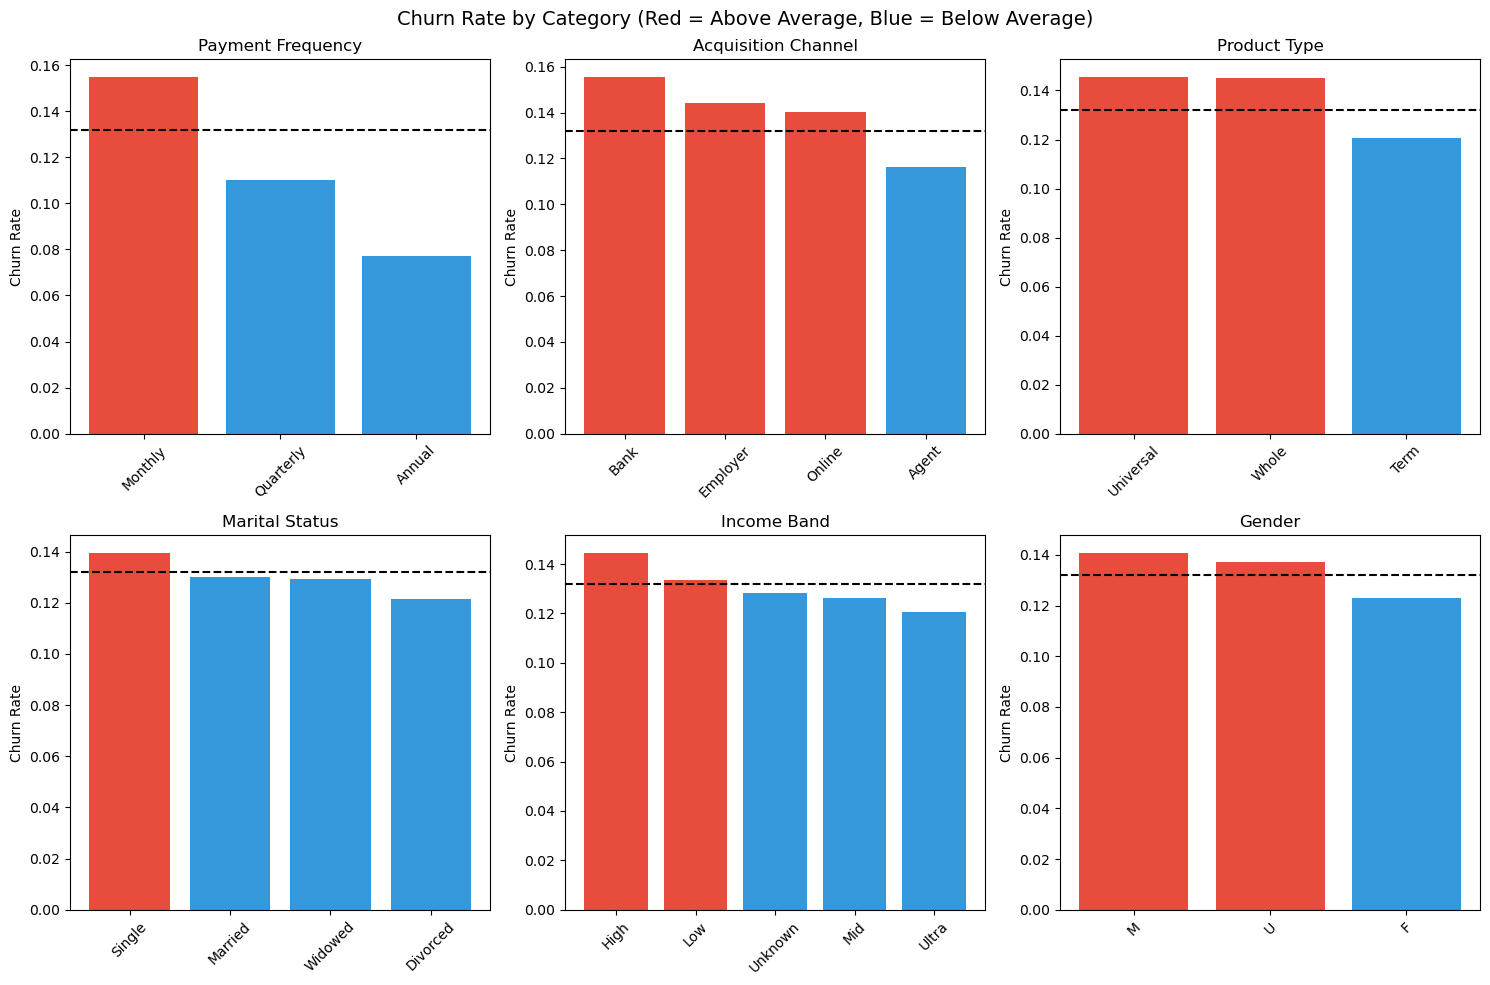

In [46]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

categories = ['payment_frequency', 'acquisition_channel', 'product_type', 
              'marital_status', 'income_band', 'customer_gender']
titles = ['Payment Frequency', 'Acquisition Channel', 'Product Type', 
          'Marital Status', 'Income Band', 'Gender']

for ax, col, title in zip(axes.flatten(), categories, titles):
    churn_rate = df.groupby(col)['churned'].mean().sort_values(ascending=False)
    colors = ['#e74c3c' if v > df['churned'].mean() else '#3498db' for v in churn_rate.values]
    ax.bar(churn_rate.index, churn_rate.values, color=colors)
    ax.axhline(y=df['churned'].mean(), color='black', linestyle='--')
    ax.set_title(title)
    ax.set_ylabel('Churn Rate')
    ax.tick_params(axis='x', rotation=45)

plt.suptitle('Churn Rate by Category (Red = Above Average, Blue = Below Average)', fontsize=14)
plt.tight_layout()
plt.show()

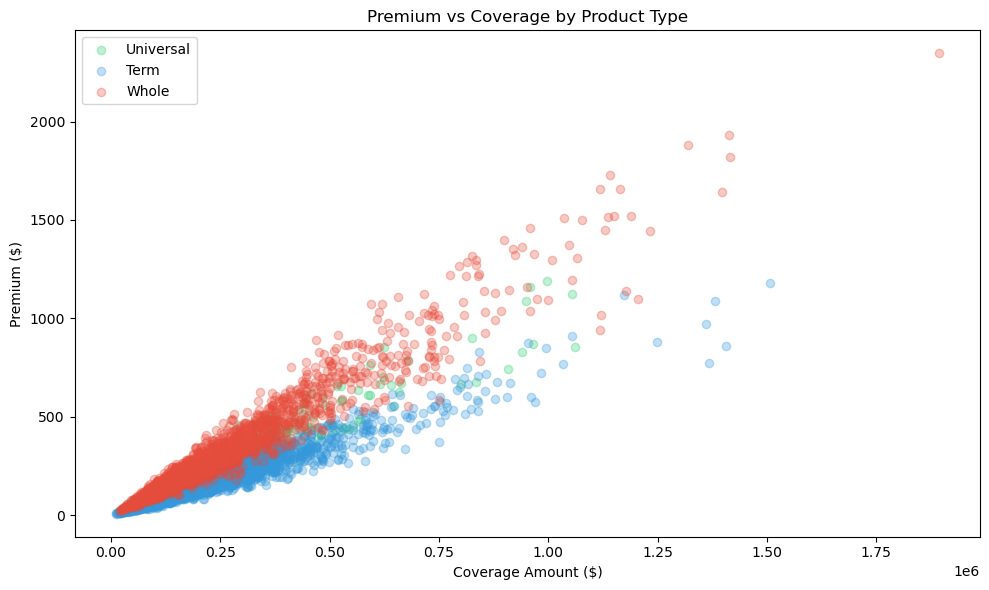

In [49]:
## Question 2
plt.figure(figsize=(10, 6))
colors = {'Term': '#3498db', 'Whole': '#e74c3c', 'Universal': '#2ecc71'}

for product in df['product_type'].unique():
    subset = df[df['product_type'] == product]
    plt.scatter(subset['coverage_amount'], subset['premium'], 
                alpha=0.3, label=product, color=colors[product])

plt.xlabel('Coverage Amount ($)')
plt.ylabel('Premium ($)')
plt.title('Premium vs Coverage by Product Type')
plt.legend()
plt.tight_layout()
plt.show()

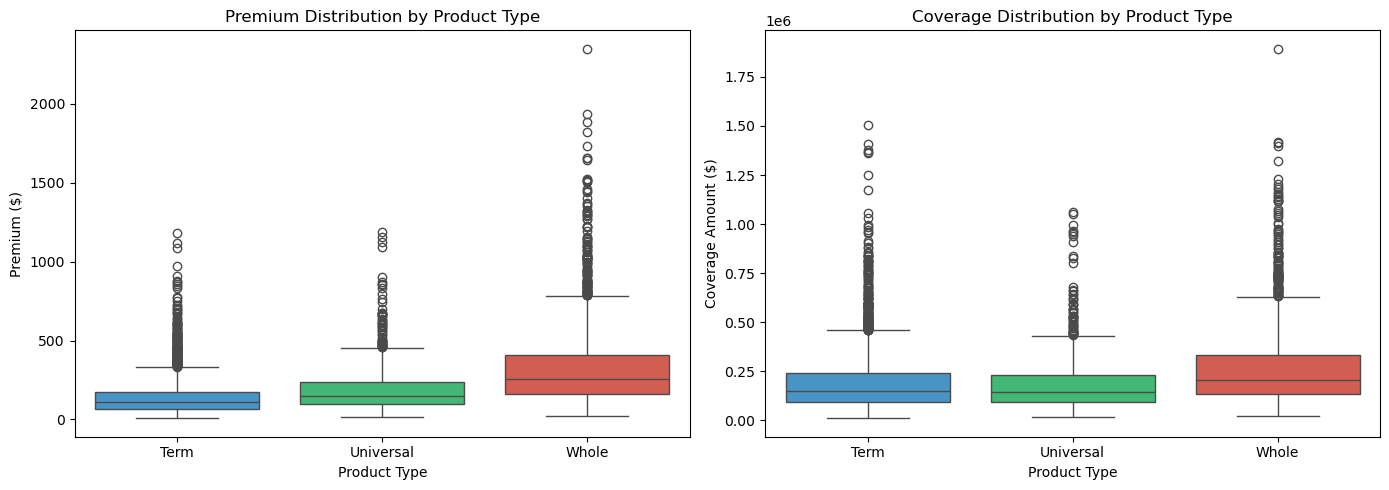

In [50]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Premium
sns.boxplot(data=df, x='product_type', y='premium', ax=axes[0], 
            order=['Term', 'Universal', 'Whole'], hue='product_type', legend=False,
            palette={'Term': '#3498db', 'Universal': '#2ecc71', 'Whole': '#e74c3c'})
axes[0].set_title('Premium Distribution by Product Type')
axes[0].set_xlabel('Product Type')
axes[0].set_ylabel('Premium ($)')

# Right: Coverage
sns.boxplot(data=df, x='product_type', y='coverage_amount', ax=axes[1],
            order=['Term', 'Universal', 'Whole'], hue='product_type', legend=False,
            palette={'Term': '#3498db', 'Universal': '#2ecc71', 'Whole': '#e74c3c'})
axes[1].set_title('Coverage Distribution by Product Type')
axes[1].set_xlabel('Product Type')
axes[1].set_ylabel('Coverage Amount ($)')

plt.tight_layout()
plt.show()

## Question 2: How does premium vs. coverage behave across product types?

### Premium by Product Type

| Product Type | Avg Premium | Median Premium | Count |
|--------------|-------------|----------------|-------|
| Term         | 140         | 109            | 3253  |
| Universal    | 195         | 152            | 887   |
| Whole        | 333         | 255            | 1860  |

### Coverage by Product Type

| Product Type | Avg Coverage | Median Coverage |
|--------------|--------------|-----------------|
| Term         | 200K         | 149K            |
| Universal    | 200K         | 147K            |
| Whole        | 266K         | 207K            |

### Key Insights

1. **Term is the most cost-effective product** - Lowest premium with similar coverage to Universal. This explains why it's the most popular product (54% of policies).

2. **Whole is the most expensive** - Premium is ~2.4x higher than Term, but coverage is only ~1.4x higher. Customers pay significantly more per dollar of coverage.

3. **Universal sits in the middle** - Slightly higher premium than Term for similar coverage, offering a balance between cost and flexibility.

4. **Linear relationship** - All products show a clear linear relationship between premium and coverage, with no anomalies detected.

5. **Variance differs by product** - Whole has the widest spread in both premium and coverage, suggesting a more diverse customer base. Term has consistent pricing across different coverage levels.

### Business Implication

The premium-to-coverage ratio reflects the nature of each product:

- **Term**: Pure protection, time-limited → cheapest
- **Universal**: Flexible, some cash value → mid-range  
- **Whole**: Lifetime coverage + savings component → most expensive

Customers choosing Whole are likely prioritizing long-term value accumulation over short-term cost efficiency.

In [51]:
# === Question 3: Channels and Payment Methods Analysis ===

# Channel Analysis
channel = df.groupby('acquisition_channel').agg({
    'churned': 'mean',
    'policy_id': 'count',
    'premium': 'mean',
    'tenure_months': 'mean'
}).round(2)
channel.columns = ['Churn Rate', 'Count', 'Avg Premium', 'Avg Tenure']
channel['% of Total'] = (channel['Count'] / channel['Count'].sum() * 100).round(1)
print("=== Channel Analysis ===")
print(channel.sort_values('Churn Rate', ascending=False))

# Payment Frequency Analysis
payment = df.groupby('payment_frequency').agg({
    'churned': 'mean',
    'policy_id': 'count',
    'premium': 'mean',
    'tenure_months': 'mean'
}).round(2)
payment.columns = ['Churn Rate', 'Count', 'Avg Premium', 'Avg Tenure']
payment['% of Total'] = (payment['Count'] / payment['Count'].sum() * 100).round(1)
print("\n=== Payment Frequency Analysis ===")
print(payment.sort_values('Churn Rate', ascending=False))

=== Channel Analysis ===
                     Churn Rate  Count  Avg Premium  Avg Tenure  % of Total
acquisition_channel                                                        
Bank                       0.16    875       210.45       83.76        14.6
Employer                   0.14    582       209.61       82.60         9.7
Online                     0.14   1840       205.23       84.83        30.7
Agent                      0.12   2703       208.15       83.36        45.1

=== Payment Frequency Analysis ===
                   Churn Rate  Count  Avg Premium  Avg Tenure  % of Total
payment_frequency                                                        
Monthly                  0.15   3587       218.97       84.61        59.8
Quarterly                0.11   1543       194.34       82.44        25.7
Annual                   0.08    870       185.17       82.83        14.5


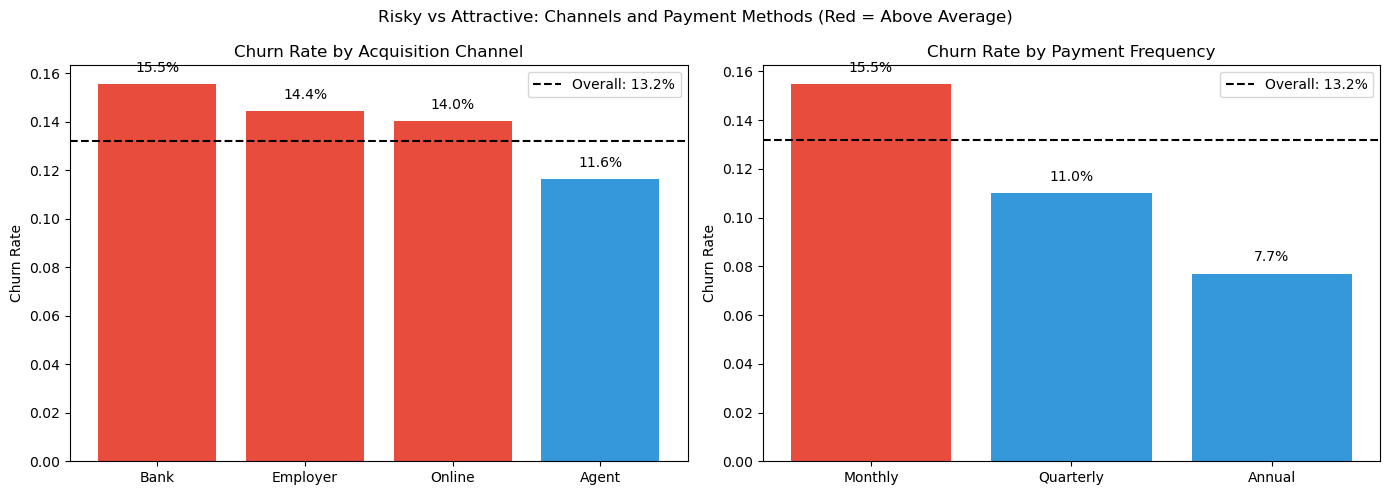

In [52]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Churn Rate by Channel
channel_churn = df.groupby('acquisition_channel')['churned'].mean().sort_values(ascending=False)
ax1 = axes[0]
colors1 = ['#e74c3c' if v > df['churned'].mean() else '#3498db' for v in channel_churn.values]
bars1 = ax1.bar(channel_churn.index, channel_churn.values, color=colors1)
ax1.axhline(y=df['churned'].mean(), color='black', linestyle='--', label=f'Overall: {df["churned"].mean():.1%}')
ax1.set_ylabel('Churn Rate')
ax1.set_title('Churn Rate by Acquisition Channel')
ax1.legend()
for i, v in enumerate(channel_churn.values):
    ax1.text(i, v + 0.005, f'{v:.1%}', ha='center')

# Right: Churn Rate by Payment Frequency
payment_churn = df.groupby('payment_frequency')['churned'].mean().sort_values(ascending=False)
ax2 = axes[1]
colors2 = ['#e74c3c' if v > df['churned'].mean() else '#3498db' for v in payment_churn.values]
bars2 = ax2.bar(payment_churn.index, payment_churn.values, color=colors2)
ax2.axhline(y=df['churned'].mean(), color='black', linestyle='--', label=f'Overall: {df["churned"].mean():.1%}')
ax2.set_ylabel('Churn Rate')
ax2.set_title('Churn Rate by Payment Frequency')
ax2.legend()
for i, v in enumerate(payment_churn.values):
    ax2.text(i, v + 0.005, f'{v:.1%}', ha='center')

plt.suptitle('Risky vs Attractive: Channels and Payment Methods (Red = Above Average)', fontsize=12)
plt.tight_layout()
plt.show()

## Question 3: Are there channels or payment methods that look risky or attractive?

### Channel Analysis

| Channel | Churn Rate | Count | Avg Premium |
|---------|------------|-------|-------------|
| Bank | 16% | 875 | 210 |
| Employer | 14% | 582 | 210 |
| Online | 14% | 1840 | 205 |
| Agent | 12% | 2703 | 208 |

### Payment Frequency Analysis

| Payment | Churn Rate | Count | Avg Premium |
|---------|------------|-------|-------------|
| Monthly | 15% | 3587 | 219 |
| Quarterly | 11% | 1543 | 194 |
| Annual | 8% | 870 | 185 |

### Key Insights

**Attractive (Low Risk):**

- **Agent channel**: Lowest churn (12%) and largest volume (45% of policies). Personal relationships drive retention.
- **Annual payment**: Lowest churn (8%). Long-term commitment signals customer loyalty.

**Risky (High Risk):**

- **Bank channel**: Highest churn (16%). Customers acquired through banks may be less engaged.
- **Monthly payment**: Highest churn (15%) but also highest average premium.

### Recommendation

Consider incentives to convert Monthly payers to Annual to reduce churn while maintaining customer value.

## Business Narrative

### Key Business Insights

Our analysis of 6,000 life insurance policies reveals three critical findings for reducing churn and improving customer retention. First, payment frequency is the strongest predictor of churn - customers paying monthly have twice the churn rate (15%) compared to annual payers (8%), suggesting that long-term commitment correlates with loyalty. Second, the acquisition channel matters significantly - Agent-acquired customers show the lowest churn (12%) and represent 45% of our portfolio, while Bank-acquired customers have the highest churn (16%), indicating that personal relationships drive retention. Third, customer tenure is a major risk factor - churned customers have 25% shorter tenure on average, meaning new customers are most vulnerable and require early engagement.

### Recommended Follow-up Actions

1. **Payment conversion program**: Offer incentives (e.g., 5-10% discount) to convert Monthly payers to Annual, reducing churn risk while maintaining customer lifetime value.

2. **Early engagement initiative**: Develop a targeted retention program for customers in their first 12-24 months, when churn risk is highest.

3. **Channel strategy review**: Investigate why Bank channel underperforms - consider additional onboarding support or qualifying criteria for Bank-acquired customers.

4. **Predictive model development**: Build a churn prediction model using the identified risk factors (payment frequency, channel, tenure, late payments) to enable proactive intervention.

## Bonus: Feature Engineering for Churn Model

**1. Channel-Payment Risk Combination**
```python
df['channel_payment'] = df['acquisition_channel'] + '_' + df['payment_frequency']
```
**Why:** We found that specific combinations have extreme churn rates (Employer+Monthly: 18.2% vs Agent+Annual: ~8%). This interaction captures risk that neither field alone reveals.

**2. Service Call Intensity**
```python
df['calls_per_year'] = df['customer_service_calls'] / (df['tenure_months'] / 12)
```
**Why:** Medium-frequency callers (0.5-1 calls/year) show 18.8% churn vs 13.2% overall. They're dissatisfied enough to call but not getting resolution.

**3. Customer Engagement Score (new data to collect)**

**Why:** Combining: login frequency to customer portal, email open rates, response to renewal reminders. Low engagement predicts churn before financial signals appear.

In [59]:
df['channel_payment'] = df['acquisition_channel'] + '_' + df['payment_frequency']
print(df.groupby('channel_payment')['churned'].mean().sort_values(ascending=False))


channel_payment
Employer_Monthly      0.181548
Bank_Monthly          0.167286
Online_Monthly        0.167123
Bank_Annual           0.144068
Agent_Monthly         0.136588
Bank_Quarterly        0.132420
Online_Quarterly      0.122581
Agent_Quarterly       0.099281
Employer_Annual       0.097561
Employer_Quarterly    0.091463
Online_Annual         0.064286
Agent_Annual          0.061538
Name: churned, dtype: float64


## Explanation feature 1
Employer_Monthly has 18.2% churn vs Agent_Quarterly 9.9% - the combination reveals risk that neither field alone captures.

In [58]:
df['calls_per_year'] = df['customer_service_calls'] / (df['tenure_months'] / 12)
df['service_intensity'] = pd.cut(df['calls_per_year'], 
                                  bins=[-0.1, 0, 0.5, 1, float('inf')], 
                                  labels=['No Calls', 'Low (0-0.5/yr)', 'Medium (0.5-1/yr)', 'High (>1/yr)'])
print("\n=== Feature 2: Service Call Intensity ===")
print(df.groupby('service_intensity', observed=True)['churned'].agg(['mean', 'count']).sort_values('mean', ascending=False))

print(f"\nOverall churn: {df['churned'].mean():.1%}")


=== Feature 2: Service Call Intensity ===
                       mean  count
service_intensity                 
Medium (0.5-1/yr)  0.187500    368
High (>1/yr)       0.144092    347
No Calls           0.132593   2700
Low (0-0.5/yr)     0.121857   2585

Overall churn: 13.2%


## Explanation feature 2
Medium-frequency callers (0.5-1/yr) have 18.8% churn vs Low-frequency (0-0.5/yr) 12.2% - the normalized rate reveals risk that raw call count alone misses